### A billion import statements:

Imports of note:
+ mesa is the library I use for agent based modeling. https://mesa.readthedocs.io/en/latest/
+ numpy and pandas are used for data manipulation. https://numpy.org/ | https://pandas.pydata.org/
+ matplotlib is used for graphing. https://matplotlib.org/
+ networkx is used to create the network representation of the tree and for graphing. https://networkx.org/


In [67]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from networkx.classes.function import get_node_attributes, set_node_attributes, set_edge_attributes, get_edge_attributes
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout, read_dot
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import itertools
import random

### Settings:


In [68]:
colony = True #if false, individual model. If true, colony model.


### Parameters for the model:

In [69]:
parameters = {
    'left' : 1, # left bias
    'right' : 1.074, # right bias
    'width' : 0.51, # width bias
    'u-turn' : 1, # u-turn bias

    'padd' : 0.1, # the amount of pheromone added by an ant in 1 time step (0.1)
    'pdecay' : -0.01, # the amount of pheromone decayed every time step on the entire tree (-0.01)

    'leave_home' : 0.10 # the probability for an ant to leave their home
}

## Tree construction functions:

#### 1. Construction of a balanced tree's leaf maps.
+ Given a weight map of the outermost tips, proceeding from left to right, and a desired depth of the tree, builds a balanced tree's leaf map in the following form:
    + The leaf map is a dictionary where a leaf's name is the key for its weight.
    + Leaves are named with 'LR' nomenclature, meaning that a leaf is named by the right or left turns required to get to it. For example, the leftmost leaf is named OLL...LL. The O demarcates the starting node.
    + Leaves are given weight by the weight map.

In [70]:
def balanced_tree(depth=5, weight_map = [0.338,0.253,0.253,0.253,0.338,0.45,0.253,0.338,0.338,0.45,0.6,0.45,0.338,0.45,0.253,0.338,0.338,0.45,0.253,0.338,0.253,0.338,0.253,0.253,0.45,0.6,0.338,0.45,0.338,0.45,0.338,0.253]):
    """
    Inputs: a 'depth' of the tree and a map of the weights of the leaves. Weights proceed from left most tip and then clock-wise around the tree.
    Output: a dictionary of leaf names with LR nomenclature and corresponding weights
    """
    leaf_names = []
    uniques = list(''.join(tup) for tup in itertools.product('LR', repeat = depth))
    weight_map.reverse()
    for i in range(2**depth):
        leaf_names += ['O'+ uniques[i]]

    leafd = {}
    i=0
    for leaf in leaf_names:
        leafd[leaf] = weight_map[i]
        i+=1

    return leafd

#### 2. Construction of a balanced tree from a leaf map.
+ Given a leaf map, constructs a tree in networkx. The tree is built through joins of leaves, where a node is created to connect two leaves and its associated weight is the larger of the weights of the leaves. This process is repeated until reaching the center node.

In [71]:
def construct_tree(leaves=balanced_tree(), fooddist=['Food','Food','Nest','Node','Food','Food','Node','Nest','Node','Nest','Food','Food','Food','Food','Nest','Node','Node','Nest','Food','Food','Node','Nest','Food','Food','Nest','Node','Food','Food','Node','Nest','Food','Food']):
    """
    Input: a dictionary of leaf names and branch widths leading to the leaves. Leaves are named with the convention 'LRLLRL', dictating how to get to the leaf.
     + Also fooddist, a list of the tip types traveling clockwise. Used in the colony model.
    Outputs: a tree constructed in networkx following the tree building rules (joining of LR names and weights).
    """
    leafd = leaves
    G = nx.Graph()
    if colony:
        i = 0
        for leaf in leafd:
            G.add_node(leaf, ntype = fooddist[i], ants=0) # Set leaves as a Food, Nest, or a Node
            i+=1
    else:
        for leaf in leafd:
            G.add_node(leaf, nest=True, ants=0)

    while not 'O' in leafd:

        leaf = list(leafd.keys())[0]

        for leaf2 in leafd:
            if leaf2 != leaf and len(leaf2) == len(leaf):
                if leaf2[:len(leaf2)-1] == leaf[:len(leaf)-1]:
                    junc = leaf[:len(leaf)-1] # The junction between two nodes is their name with the last letter cut off
                    if colony: 
                        if junc == 'O':
                            G.add_node(junc, ntype = "Home", ants=0) # Set start node as home
                        else:
                            G.add_node(junc, ntype = "Node", ants=0) # Other nodes are normal
                    else: 
                        G.add_node(junc, nest = False, ants=0)

                    G.add_edge(junc, leaf2, weight = leafd[leaf2], p = 0)
                    G.add_edge(junc, leaf, weight = leafd[leaf], p = 0)
                    
                    
                    leafd[junc] = (leafd[leaf] if leafd[leaf] > leafd[leaf2] else leafd[leaf2])
                    del leafd[leaf]
                    del leafd[leaf2]
                    break
    
    return G

#### 3. Drawing of the network and graph following an experiment.
+ Called by experiment(), given a network, G, and the data from the experiment, constructs graph and network images.

In [72]:
def graph_draw(G,data,labels_ordered=True):
    """
    Inputs: G, a tree in networkx and data from the Mesa model. Data is in the form of dictionary with time steps. Gross conversions proceed. Labels_ordered dictacts what naming scheme to use (True = clockwise, False = lab).
    Output: draws a networkx plot and an area plot from a pandas dataframe
    """
    datan = list(G.nodes(data=True))
    nodes = G.nodes()
    node_size_map = []
    i = 0
    for node in G:
        node_size_map+=[datan[i][1]['ants'] *10 + 20]
        i+=1

    G = nx.relabel_nodes(G, lambda name: (int(name.replace('L','0').replace('R','1')[1:],2)+1) if len(name) == 6 else name)
    G = nx.relabel_nodes(G, lambda name: (chr(((name-1)//4) + 65) + str((name-1)%4) if isinstance(name,int) else name)) # Changes node labels from LR to clockwise
    pos = graphviz_layout(G, prog = 'twopi') #prog = 'dot' for other view
    plt.title(str(parameters))
    
    
    colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive']
    color_map = []
    datan = list(G.nodes(data=True))
    i = 0
    if colony: 
        for node in G:
            if datan[i][1]['ntype'] == 'Nest':
                color = clr.to_rgba(colors[ord(node[0])-65])
                color_map.append(color)
            elif datan[i][1]['ntype'] == "Home":
                color_map.append(clr.to_rgba('red')) 
            elif datan[i][1]['ntype'] == "Food":
                color = clr.to_rgba('grey')
                color = (color[0],color[1],color[2], color[3] - 0.5)
                color_map.append(color) 
            else: 
                color = clr.to_rgba('blue')
                color = (color[0],color[1],color[2], color[3] - 0.5)
                color_map.append(color) 
            i+=1
    else: 
        for node in G:
            if datan[i][1]['nest'] == True:
                color = clr.to_rgba(colors[ord(node[0])-65])
                color = (color[0],color[1],color[2], color[3]*(int(node[1])/3.5) +0.14)
                color_map.append(color)
            elif node == 'O':
                color_map.append(clr.to_rgba('red')) 
            else: 
                color_map.append(clr.to_rgba('blue')) 
            i+=1

    
    color_map_edge = []

    weight_map = [G[u][v]['weight'] * 5 for u,v in G.edges()]
    for weight in weight_map:
        if weight == 0.253 * 5:
            color_map_edge += ['lightgrey']
        elif weight == 0.338 * 5:
            color_map_edge += ['darkgrey']
        elif weight == 0.45 * 5:
            color_map_edge += ['grey']
        else:
            color_map_edge += ['black']

    if not labels_ordered:
        d = {"C0":'1111',"C1":'1112',"C2":'1121',"C3":'1122','D0':'1211','D1':'1212','D2':'1221','D3':'1222','G0':'2111','G1':'2112','G2':'2121','G3':'2122','H0':'2211','H1':'2212','H2':'2221','H3':'2222','A0':'311','A1':'312','A2':'321','A3':'322','E0':'411','E1':'412','E2':'421','E3':'422','B0':'51','B1':'52','F2':'61','F3':'62','B2':'71','B3':'72','F0':'81','F1':'82'}
        G = nx.relabel_nodes(G, d)
        pos = graphviz_layout(G, prog = 'twopi')

    name_map = {}
    for node in G.nodes():
        if not node[0] == 'O':
            name_map[node] = node


    nx.draw_networkx(G, pos, node_color=color_map, node_size=node_size_map, edge_color = color_map_edge, with_labels=False, width = weight_map)
    nx.draw_networkx_labels(G,pos,name_map,font_size=16,font_color='black')
    plt.gca().invert_xaxis()
   
    # Creating the area plot
    datadict = {}
    datadictlist = [datadict]
    for i in range(int(len(data['Position'])/len(data['Position'][0]))):
        
        for k in range(len(data['Position'][i])):
            if not data['Position'][i][k] in datadict:
                datadict[data['Position'][i][k]] = 1
            else:
                datadict[data['Position'][i][k]] += 1

        for node in nodes:
            if not node in datadict:
                datadict[node] = 0
            

        datadictlist+=[datadict]
        datadict = {}
    datadictlist = datadictlist[1:]

    ax = pd.DataFrame(datadictlist).plot.area(colormap=clr.ListedColormap([color_map[-1]]+color_map[:-1]))
    
    ax.set_ylabel('ants')
    ax.set_xlabel('time')

    ax.get_legend().remove()
    plt.title(str(parameters))
    
    plt.show()

## Agent Class
A class which stores information about position and previous position.

In [73]:
class States(enum.Enum): # for colony model only
    """
    Enum class listing the possible ant states
    """
    WAITING_HOME = 0
    WAITING_NEST = 1
    SEARCHING = 2
    RETURNING = 3

class AgAnt(Agent):
    """
    The AgAnt class is a custom agent class in mesa, with unique ids and created in a specified model. They store information about their position (node O to start) and previous positions.
    They make decisions about where to move based on their previous position, current position, and biases. Agents do not interact in this model.
    """
    def __init__(self,unique_id,model):
        super().__init__(unique_id,model)
        self.pos = 'O'
        self.ppos = None
        if colony: self.state = States.WAITING_HOME

    def choice(self,neighbors):
        """
        Inputs: self, list of neighbors.
        Outputs: A choice of neighbor to move to next based on the options availible and biases.
        """
        if len(neighbors) == 1:
                return neighbors[0]
        
        else:
            for i in range(len(neighbors)):
                neighbors[i] = [neighbors[i] , self.model.G.get_edge_data(self.pos, neighbors[i])]

            if len(neighbors) == 2:
                if colony: probs = [neighbors[0][1]['weight']**parameters['width'] + neighbors[0][1]['p'] , neighbors[1][1]['weight']**parameters['width'] + neighbors[1][1]['p']]
                else: probs = [neighbors[0][1]['weight'],neighbors[1][1]['weight']]

                for i in range(len(probs)):
                    if not colony: probs[i] **= parameters['width']
                    if neighbors[i][0][-1] == 'L':
                        probs[i] *= parameters['left']
                    elif neighbors[i][0][-1] == 'R':
                        probs[i] *= parameters['right']
                    else:
                        probs[i] *= parameters['u-turn']

                total = probs[0]+probs[1]
                probs[0] = probs[0]/total
                probs[1] = probs[1]/total
            
                r = random.random()
                if r < probs[0]:
                    return neighbors[0][0]
                else:
                    return neighbors[1][0]

            else: 
                if colony: probs = [neighbors[0][1]['weight']**parameters['width'] + neighbors[0][1]['p'],neighbors[1][1]['weight']**parameters['width'] + neighbors[1][1]['p'],neighbors[2][1]['weight']**parameters['width'] + neighbors[2][1]['p']]
                else: probs = [neighbors[0][1]['weight'],neighbors[1][1]['weight'],neighbors[2][1]['weight']]
                
                if len(self.ppos) < len(self.pos): #if facing 'forwards'
                    for i in range(len(probs)):
                        if not colony: probs[i] **= parameters['width']

                        if neighbors[i][0] == self.ppos:
                            probs[i] *= parameters['u-turn']
                        elif neighbors[i][0][-1] == 'L':
                            probs[i] *= parameters['left']
                        elif neighbors[i][0][-1] == 'R':
                            probs[i] *= parameters['right']
                else: #if facing 'backwards'
                    for i in range(len(probs)):
                        if not colony: probs[i] **= parameters['width']

                        if neighbors[i][0] == self.ppos:
                            probs[i] *= parameters['u-turn']
                        elif neighbors[i][0][-1] == 'L':
                            probs[i] *= parameters['right']
                        elif neighbors[i][0][-1] == 'R':
                            probs[i] *= parameters['left']
                        
                total = probs[0]+probs[1]+probs[2]
                probs[0] = probs[0]/total
                probs[1] = probs[1]/total
                probs[2] = probs[2]/total

                r = random.random()
                if r < probs[0]:
                    return neighbors[0][0]
                elif r < probs[0]+probs[1]:
                    return neighbors[1][0]
                else:
                    return neighbors[2][0]

    def move(self):
        """
        Moves the ant if not at a nest, otherwise does not.
        """
        if colony: 
            if self.state == States.RETURNING:
                neighbors = list(self.model.G.neighbors(self.pos))
                    
                node = self.choice(neighbors)

                ants = {self.pos : {'ants' : get_node_attributes(self.model.G, 'ants')[self.pos] - 1}, node : { 'ants' : get_node_attributes(self.model.G, 'ants')[node] + 1}}
                p = {(self.pos,node) : {'p' : self.model.G.get_edge_data(self.pos,node)['p'] + parameters['padd']}}
                self.ppos = self.pos
                self.model.grid.move_agent(self, node)
                set_node_attributes(self.model.G, ants)
                set_edge_attributes(self.model.G, p)

            elif self.state == States.SEARCHING:
                neighbors = list(self.model.G.neighbors(self.pos))
                
                node = self.choice(neighbors)

                ants = {self.pos : {'ants' : get_node_attributes(self.model.G, 'ants')[self.pos] - 1}, node : { 'ants' : get_node_attributes(self.model.G, 'ants')[node] + 1}}
                self.ppos = self.pos
                self.model.grid.move_agent(self, node)
                set_node_attributes(self.model.G, ants)
            
        else: 
            if get_node_attributes(self.model.G, 'nest')[self.pos]:
                return self.pos
            else:
                neighbors = list(self.model.G.neighbors(self.pos))
                
                node = self.choice(neighbors)

                ants = {self.pos : {'ants' : get_node_attributes(self.model.G, 'ants')[self.pos] - 1}, node : { 'ants' : get_node_attributes(self.model.G, 'ants')[node] + 1}}
                self.ppos = self.pos
                self.model.grid.move_agent(self, node)
                set_node_attributes(self.model.G, ants)

            return node

    def update(self):
        """
        Updates the ant's state based on their position in the tree.
        """
        if get_node_attributes(self.model.G, 'ntype')[self.pos] == 'Nest':
            self.state = States.WAITING_NEST
        elif get_node_attributes(self.model.G, 'ntype')[self.pos] == 'Food':
            self.state = States.RETURNING
        elif get_node_attributes(self.model.G, 'ntype')[self.pos] == 'Home':
            self.state = States.WAITING_HOME

    def step(self):
        if not colony: 
            self.move()
        else:
            if self.state == States.WAITING_HOME:
                if random.random() < parameters['leave_home']:
                    self.state = States.SEARCHING
                    self.move()

            elif self.state == States.WAITING_NEST:
                p0 = parameters['leave_home']
                r = 0.2
                a = 10
                x = get_node_attributes(self.model.G, 'ants')[self.pos]
                chance = -((1-p0)/(1 + math.exp(-r*(x-a)))) + 1
                if random.random() < chance:
                    self.state = States.RETURNING
                    self.move()

            elif self.state == States.SEARCHING: 
                self.move()
            
            elif self.state == States.RETURNING:
                self.move()
            
            self.update()

## Model Class
A class which stores information about the network and model, so data can be collected and analyzed.

In [74]:
class TreeModel(Model):
    """
    TreeModel class has a tree, schedule (order in which to activate agents), grid (network), and a datacollector (what data to collect, position in this case)
    """

    def __init__(self, G, pop):
        self.G = G
        self.schedule = RandomActivation(self)
        self.grid = NetworkGrid(self.G)
        for i in range(pop):
            ant = AgAnt(i, self)

            self.schedule.add(ant)
            self.grid.place_agent(ant, 'O')
        ants = {'O' : {'ants' : pop}}
        set_node_attributes(self.G, ants)

        self.datacollector = DataCollector(agent_reporters={'Position' : "pos"})
        

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if colony: self.updatep(self.G)
    
    def updatep(self, G):
        """
        Updates pheromones based on pdecay, but doesn't go below 0.
        """
        p = get_edge_attributes(G,'p')
        for key in p:
            p[key] = p[key] + parameters['pdecay']
            if p[key] < 0:
                p[key] = 0
    

## Analytical functions:

In [75]:
def sim(n = 10, ants = 100, data = False):
    """
    Sim runs a model for n steps on ants ants, and returns either the tree on its own or the data too if specified. The default tree is provided below.
    """

    model = TreeModel(construct_tree(balanced_tree(depth=5, weight_map = [0.338,0.253,0.253,0.253,0.338,0.45,0.253,0.338,0.338,0.45,0.6,0.45,0.338,0.45,0.253,0.338,0.338,0.45,0.253,0.338,0.253,0.338,0.253,0.253,0.45,0.6,0.338,0.45,0.338,0.45,0.338,0.253])), ants)
    for i in range(n):
        model.step()
        
    if data:
        return model.G, model.datacollector.get_agent_vars_dataframe()

    return model.G

def experiment(n=50, ants = 1000, relabel=True):
    """
    experiment simply calls sim then draws the graphs. relabel true means clockwise labels, false means lab labels.
    Sample run: experiment(50,1000)
    """
    G,data = sim(n,ants,True)
    graph_draw(G,data,relabel)

## Function calls to try:

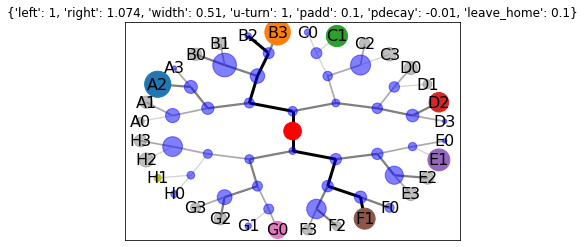

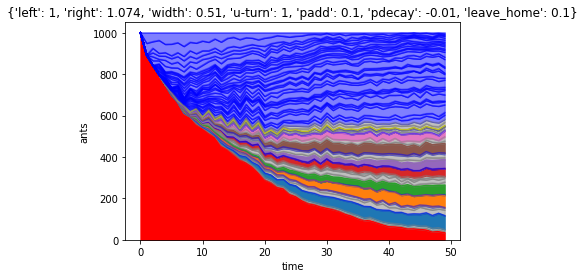

In [76]:
experiment(50,1000)